In [ ]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
import os


from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras

from keras import optimizers
from keras.layers import Dense, Dropout,LSTM


In [ ]:
WINDOW = 4
HORIZON = 8

n_steps = 24 * WINDOW
n_features = HORIZON

def fillna(df):
  return df.fillna(method = 'ffill')

def fillna_interpolation(df):
  new_df = df.copy()
  for feature_var in new_df:
    series = new_df[feature_var]
    series = series.interpolate(method = 'linear')
    # series = series.interpolate(method = 'spline', order = 2)
    # series = series.interpolate(method = 'polynomial', order = 3)

    new_df.loc[:, feature_var] = series
  return new_df




def convert_time(df):
  time_index = pd.to_datetime(df[df.columns[:4]])
  clean_data = pd.DataFrame(time_index).join(df, on = time_index.index).rename({0: 'Time'}, axis = 1)
  clean_data.drop(['year', 'month', 'day', 'hour'], inplace = True, axis = 1)
  return clean_data

def cleaning_X(df):
  df = df.drop("No", axis = 1)
  df = convert_time(df)
  return df.drop("Time", axis = 1)


def normalize(train_df):
  train_mean = train_df.mean()
  train_std = train_df.std()

  train_df = (train_df - train_mean) / train_std
  return train_df

def categorical_process(df_clean):
  cat_attribs = ['wd']
  full_pipeline = ColumnTransformer([
    ("cat", OneHotEncoder(categories='auto', handle_unknown= 'ignore'), cat_attribs)
  ], remainder = 'passthrough')
  df_prepared = full_pipeline.fit_transform(df_clean)
  return df_prepared

def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    Denoises data using the fast fourier transform.
    References
    ----------
    [1] Steve Brunton - Denoising Data with FFT[Python]
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

def denoise_data(df):
  ROLLING = 15
  df_copy = df.copy()
  for feature_var in df_copy:
    series = df_copy[feature_var]
    series = series.rolling(ROLLING).mean().dropna(axis = 0, how = 'all')
    series = series.to_numpy()
    series = fft_denoiser(series, 0.95)
    df_copy.loc[ROLLING - 1: , feature_var] = series

  return df_copy


def preprocessing_data(df):
  df_clean = cleaning_X(df.copy())
  df_clean = fillna_interpolation(df_clean)
  # print(df_clean.shape)

  num_attribs = list(df_clean.columns)[:10]
  num_attribs.append("WSPM")
  df_cat = df[['wd']]
  df_clean = normalize(df_clean[num_attribs])
  df_clean = denoise_data(df_clean)

  
  final_df_clean = df_clean.merge(df_cat, left_index = True, right_index = True)
  # print(df_clean)

  df_clean = categorical_process(final_df_clean.copy())

  return df_clean

def split_sequence(sequence, n_steps, return_x = True):
    X, y = list(), list()
    # print(len(sequence))
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1 - n_features:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix: end_ix + n_features, 17:18]
        X.append(seq_x)
        y.append(seq_y)
    if return_x:
      return np.array(X), np.array(y).reshape(-1,n_features)


def split_y_sequence(sequence, n_steps):
  y = list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence) - 1 -n_features:
      break
    seq_y = sequence[end_ix : end_ix + n_features]
    y.append(seq_y)

  return np.array(y).reshape(-1, HORIZON)

In [ ]:
df = pd.read_csv("train_aotizhongxin.csv")
df_clean = preprocessing_data(df)
#0:17 is one hot encoding
print(df_clean.shape)

df_valid = pd.read_csv("valid_aotizhongxin.csv")
df_valid_clean = preprocessing_data(df_valid)
print(df_valid_clean.shape)

df_test = pd.read_csv("test_aotizhongxin.csv")
df_test_clean = preprocessing_data(df_test)
print(df_test_clean.shape)

X, y = split_sequence(df_clean, n_steps)
print(X.shape, y.shape)



X_valid, y_valid = split_sequence(df_valid_clean, n_steps)
print(X_valid.shape, y_valid.shape)

(20448, 28)
(7320, 28)
(7296, 28)
(20344, 96, 28) (20344, 8)
(7216, 96, 28) (7216, 8)


# Testing dataset

In [ ]:
sample[['PM2.5']][168:168+n_features]

PM2.5
168  3.347338
169  3.282667
170  3.282667
171  3.088654
172  3.062786
173  2.972246
174  2.907575
175  2.894641

In [ ]:
X[0][:, 17:18][:10]

array([[-1.05028886],
       [-0.99855207],
       [-1.01148627],
       [-1.02442047],
       [-1.06322306],
       [-1.03735466],
       [-1.06322306],
       [-1.06322306],
       [-1.06322306],
       [-1.06322306]])

In [ ]:
y[0]

array([3.3473381 , 3.28266711, 3.28266711, 3.08865416, 3.06278577,
       2.97224639, 2.9075754 , 2.89464121])

# Training

In [ ]:


class Time2Vector(keras.layers.Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__(**kwargs)
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:3], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)


    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_len": self.seq_len })
        return config


#################################
# custom n-beat model
################################
class n_beat_block(tf.keras.layers.Layer):
    def __init__(self, n_neurons, n_layers, window, horizontal, **kwargs):
        super().__init__(**kwargs)
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.window = window
        self.horizontal = horizontal
        theta_size = window + horizontal
        self.hidden_layers = [keras.layers.Dense(n_neurons, activation = 'relu') for _ in range(n_layers)]
        self.theta_layer = keras.layers.Dense(theta_size, activation = 'linear')
    
    def call(self, inputs):
        x = self.hidden_layers[0](inputs)
        for layer in self.hidden_layers[1:]:
            x = layer(x)
        theta = self.theta_layer(x)
        backcast, forecast = theta[:, :self.window], theta[:, -self.horizontal:]
        return backcast, forecast

    def get_config(self):
        config = super().get_config()
        config.update({
            "n_neurons": self.n_neurons,
            "n_layer": self.n_layers,
            "window": self.window,
            "horizontal": self.horizontal
        })
        return config


class nbeat(tf.keras.layers.Layer):
    def __init__(self, n_neurons, n_layers, window, horizontal, **kwargs):
        super().__init__(**kwargs)
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.window = window
        self.horizontal = horizontal
        self.flatten = keras.layers.Flatten()
        self.hidden = [keras.layers.Dense(n_neurons, activation = 'relu') for _ in range(n_layers)]
        self.theta = keras.layers.Dense(window + horizontal, activation = 'linear')
        
    def call(self, inputs):
        x = inputs
        x = self.flatten(x)
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta(x)
        #squeeze = keras.layers.Lambda(lambda x: tf.squeeze(x))(theta)
        #backcast, forecast = squeeze[:, :window], squeeze[:, -horizontal:]
        backcast, forecast = theta[: , :self.window], theta[:, -self.horizontal:]
        return backcast, forecast


    def get_config(self):
        config = super().get_config()
        config.update({
            "n_neurons": self.n_neurons,
            "n_layer": self.n_layers,
            "window": self.window,
            "horizontal": self.horizontal
        })
        return config



def build_nbeat(window , horizontal, feature, n_block = 4, n_neurons = 64, n_layers = 2):
    inputs = keras.layers.Input(shape = (window, feature))
    time = Time2Vector(window)(inputs)
    concat = keras.layers.Concatenate(axis = -1)([inputs, time])
    nbeat_block = nbeat(n_neurons = n_neurons,
                        n_layers = n_layers,
                        window = window,
                        horizontal = horizontal)
    backcast, forecast = nbeat_block(concat)

    for _ in range(n_block):

        block_backcast, block_forecast = n_beat_block(n_neurons = n_neurons,
                                                      n_layers = n_layers,
                                                      window = window,
                                                      horizontal = horizontal)(backcast)

        forecast = keras.layers.add([forecast, block_forecast])
        backcast = keras.layers.subtract([backcast, block_backcast])

    model = keras.Model(inputs = inputs, outputs = forecast)
    return model


(20344, 96, 28) (20344, 8)
(7216, 96, 28) (7216, 8)


# N-beats Model

In [ ]:
model = build_nbeat(window = 24 * WINDOW, feature = 28, horizontal = HORIZON)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 28)]     0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 96, 2)        384         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 96, 30)       0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 nbeat (nbeat)                  ((None, 96),         195304      ['concatenate[0][0]']        

In [ ]:

model = build_nbeat(window = 24 * WINDOW, feature = 28, horizontal = HORIZON)

tf.random.set_seed(42)
optimizer = keras.optimizers.Adam(learning_rate=1e-4) # learning rate = 3e-4 for multi feature and 1e-2 for one feature
# model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer
#               )

model.compile(optimizer = 'adam', loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])    
# 
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 8, restore_best_weights= True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("custom_nbeats.h5", save_best_only = True)

# checkpoint_dir = os.path.dirname(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_cb,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

# print(model.summary())
history = model.fit(X, y,
                    validation_data = (X_valid, y_valid),
                    epochs = 30,
                    callbacks = [checkpoint_cb, early_stopping_cb])


Epoch 1/30
424/424 [==============================] - 7s 8ms/step - loss: 0.4139 - root_mean_squared_error: 0.6434 - val_loss: 0.3563 - val_root_mean_squared_error: 0.5969
Epoch 2/30
424/424 [==============================] - 3s 6ms/step - loss: 0.2524 - root_mean_squared_error: 0.5024 - val_loss: 0.4029 - val_root_mean_squared_error: 0.6347
Epoch 3/30
424/424 [==============================] - 3s 6ms/step - loss: 0.1856 - root_mean_squared_error: 0.4308 - val_loss: 0.4901 - val_root_mean_squared_error: 0.7001
Epoch 4/30
424/424 [==============================] - 3s 7ms/step - loss: 0.1462 - root_mean_squared_error: 0.3824 - val_loss: 0.4323 - val_root_mean_squared_error: 0.6575
Epoch 5/30
424/424 [==============================] - 3s 7ms/step - loss: 0.1171 - root_mean_squared_error: 0.3423 - val_loss: 0.4412 - val_root_mean_squared_error: 0.6642
Epoch 6/30
424/424 [==============================] - 3s 7ms/step - loss: 0.1010 - root_mean_squared_error: 0.3177 - val_loss: 0.5100 - val_

In [ ]:
# !pip install darts
# dart_nbeat = 

In [ ]:
train_mean = df[['PM2.5']].mean().to_numpy()
train_std = df[['PM2.5']].std().to_numpy()
print(train_mean)


# Prediction on test set
# model.load_weights(checkpoint_filepath)
X_test, y_test = split_sequence(df_test_clean, n_steps)
# recons_model = tf.keras.models.load_model("custom_nbeats.h5")

y_pred_beats = model.predict(X_test)

print(y_pred_beats.shape)

y_test_real = split_y_sequence(fillna(cleaning_X(df_test))[['PM2.5']], n_steps)
print(y_test_real.shape)

def root_mean_squared_error(y_true, y_pred):
  return tf.math.sqrt(tf.reduce_mean(tf.math.square(y_true - y_pred)))


# y_test_inverse = y_test * test_std + test_mean
y_pred_inverse_beats = y_pred_beats * train_std + train_mean
print(root_mean_squared_error(y_test_real, y_pred_inverse_beats).numpy())
mae = tf.keras.losses.MeanAbsoluteError()
print(mae(y_test_real, y_pred_inverse_beats).numpy())

[85.50490218]
225/225 [==============================] - 1s 2ms/step
(7192, 8)
(7192, 8)
48.898087282877945
31.20946328807413


(300,)

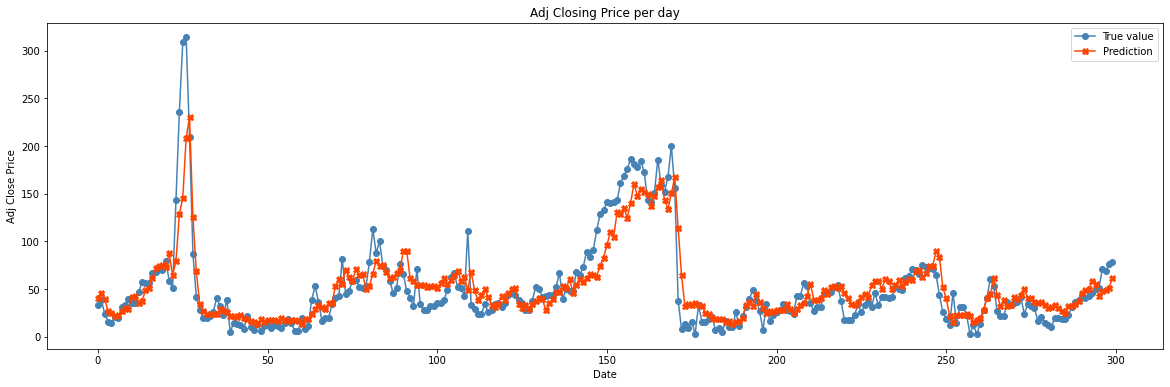

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times,y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times,pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Adj Closing Price per day')
    plt.xlabel('Date')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.show()

plot_difference(y_test_real[:300], y_pred_inverse_beats[:300])

# RNN

In [ ]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras

from keras import optimizers
from keras.layers import Dense, Dropout,LSTM, SimpleRNN, GRU
model = Sequential()
# model.add(tf.keras.layers.BatchNormalization())
model.add(SimpleRNN(units = 250, return_sequences = True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.5))

# model.add(tf.keras.layers.BatchNormalization())
# model.add(SimpleRNN(units = 200, return_sequences = True))
# model.add(Dropout(0.25))

# model.add(tf.keras.layers.BatchNormalization())
# model.add(SimpleRNN(units = 150, return_sequences = True))
# model.add(Dropout(0.2))

# model.add(tf.keras.layers.BatchNormalization())
model.add(SimpleRNN(units = 100))
model.add(Dense(units = HORIZON))

model.compile(optimizer = 'adam', loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])    
# model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])    
checkpoint_cb = keras.callbacks.ModelCheckpoint("air_train.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights= True)

hist = model.fit(X, y, validation_data = (X_valid, y_valid), epochs = 10, verbose = 1,
                 callbacks = [checkpoint_cb, early_stopping_cb])
 
train_mean = df[['PM2.5']].mean().to_numpy()
train_std = df[['PM2.5']].std().to_numpy()
print(train_mean)


# Prediction on test set
# model.load_weights(checkpoint_filepath)
X_test, y_test = split_sequence(df_test_clean, n_steps)
recons_model_rnn = tf.keras.models.load_model("air_train.h5")

y_pred = recons_model_rnn.predict(X_test)

print(y_pred.shape)

y_test_real = split_y_sequence(fillna(cleaning_X(df_test))[['PM2.5']], n_steps)
print(y_test_real.shape)

def root_mean_squared_error(y_true, y_pred):
  return tf.math.sqrt(tf.reduce_mean(tf.math.square(y_true - y_pred)))
# y_test_inverse = y_test * test_std + test_mean
y_pred_inverse = y_pred * train_std + train_mean
print(root_mean_squared_error(y_test_real, y_pred_inverse).numpy())
mae = tf.keras.losses.MeanAbsoluteError()
print(mae(y_test_real, y_pred_inverse).numpy())

Epoch 1/10
636/636 [==============================] - 91s 141ms/step - loss: 0.2494 - root_mean_squared_error: 0.4994 - val_loss: 0.1586 - val_root_mean_squared_error: 0.3982
Epoch 2/10
636/636 [==============================] - 87s 136ms/step - loss: 0.2543 - root_mean_squared_error: 0.5043 - val_loss: 0.1810 - val_root_mean_squared_error: 0.4255
Epoch 3/10
636/636 [==============================] - 85s 134ms/step - loss: 0.1864 - root_mean_squared_error: 0.4317 - val_loss: 0.0966 - val_root_mean_squared_error: 0.3109
Epoch 4/10
636/636 [==============================] - 87s 137ms/step - loss: 0.1171 - root_mean_squared_error: 0.3423 - val_loss: 0.1084 - val_root_mean_squared_error: 0.3293
Epoch 5/10
636/636 [==============================] - 85s 134ms/step - loss: 0.1036 - root_mean_squared_error: 0.3219 - val_loss: 0.0742 - val_root_mean_squared_error: 0.2724
Epoch 6/10
636/636 [==============================] - 88s 138ms/step - loss: 0.0968 - root_mean_squared_error: 0.3111 - val_l

## Prediction

In [ ]:
train_mean = df[['PM2.5']].mean().to_numpy()
train_std = df[['PM2.5']].std().to_numpy()
print(train_mean)


# Prediction on test set
# model.load_weights(checkpoint_filepath)
X_test, y_test = split_sequence(df_test_clean, n_steps)
recons_model_rnn = tf.keras.models.load_model("air_train.h5")

y_pred = recons_model_rnn.predict(X_test)

print(y_pred.shape)

y_test_real = split_y_sequence(fillna(cleaning_X(df_test))[['PM2.5']], n_steps)
print(y_test_real.shape)

def root_mean_squared_error(y_true, y_pred):
  return tf.math.sqrt(tf.reduce_mean(tf.math.square(y_true - y_pred)))
# y_test_inverse = y_test * test_std + test_mean
y_pred_inverse = y_pred * train_std + train_mean
print(root_mean_squared_error(y_test_real, y_pred_inverse).numpy())
mae = tf.keras.losses.MeanAbsoluteError()
print(mae(y_test_real, y_pred_inverse).numpy())

[84.7922072]
225/225 [==============================] - 3s 14ms/step
(7199, 1)
(7199, 1)
21.202412145675904
12.339615120874189


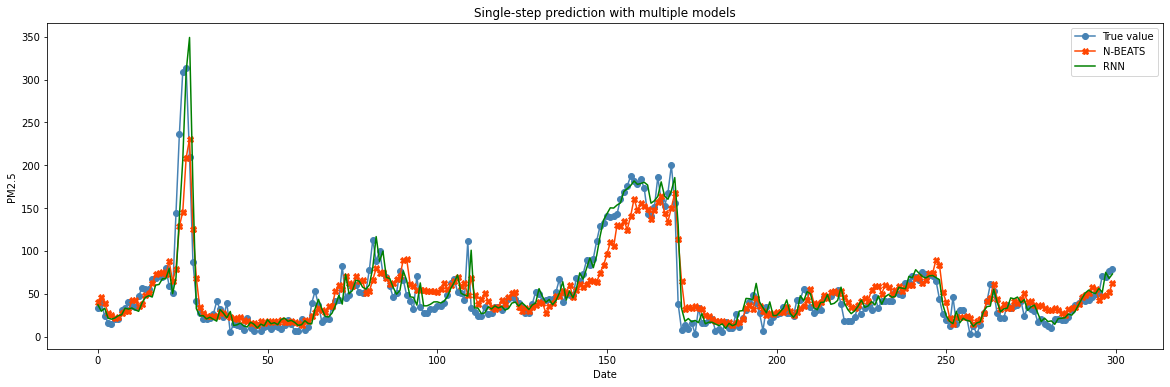

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times,y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times,pred_to_plot, color='orangered', marker='X', label='N-BEATS')
    plt.plot(times, y_pred_inverse[:300], color = 'green', label = 'RNN')

    plt.title('Single-step prediction with multiple models')
    plt.xlabel('Date')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.show()

plot_difference(y_test_real[:300], y_pred_inverse_beats[:300])

# LSTM + GRU

In [ ]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras

from keras import optimizers
from keras.layers import Dense, Dropout,LSTM, LSTM, GRU

mae_metrics = []
mse_metrics = []

y_test_inv_lst = []

def recurrent_network(layer):
  model = Sequential()
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(layer(units = 100, input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(units = HORIZON))

  model.compile(optimizer = 'adagrad', loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])    
  # model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])    
  checkpoint_cb = keras.callbacks.ModelCheckpoint(f"air_train_{layer}.h5")
  early_stopping_cb = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

  hist = model.fit(X, y, validation_data = (X_valid, y_valid), epochs = 10, verbose = 1,
                  callbacks = [checkpoint_cb, early_stopping_cb])
  
  train_mean = df[['PM2.5']].mean().to_numpy()
  train_std = df[['PM2.5']].std().to_numpy()
  print(train_mean)


  # Prediction on test set
  # model.load_weights(checkpoint_filepath)
  X_test, y_test = split_sequence(df_test_clean, n_steps)
  recons_model = tf.keras.models.load_model(f"air_train_{layer}.h5")

  y_pred = recons_model.predict(X_test)

  print(y_pred.shape)

  y_test_real = split_y_sequence(fillna(cleaning_X(df_test))[['PM2.5']], n_steps)
  print(y_test_real.shape)

  # def root_mean_squared_error(y_true, y_pred):
  #   return tf.math.sqrt(tf.reduce_mean(tf.math.square(y_true - y_pred)))
  # y_test_inverse = y_test * test_std + test_mean
  y_pred_inverse = y_pred * train_std + train_mean
  






  def root_mean_squared_error(y_true, y_pred):
    return tf.math.sqrt(tf.reduce_mean(tf.math.square(y_true - y_pred)))





  print(root_mean_squared_error(y_test_real, y_pred_inverse).numpy())
  mae = tf.keras.losses.MeanAbsoluteError()
  print(mae(y_test_real, y_pred_inverse).numpy())

  mae_metrics.append(mae(y_test_real, y_pred_inverse).numpy())
  mse_metrics.append(root_mean_squared_error(y_test_real, y_pred_inverse).numpy())


  y_test_inv_lst.append(y_pred_inverse)


networks = [LSTM, GRU]
for network in networks:
  print(network)
  recurrent_network(network)



<class 'keras.layers.rnn.lstm.LSTM'>
Epoch 1/10
636/636 [==============================] - 7s 8ms/step - loss: 0.4151 - root_mean_squared_error: 0.6443 - val_loss: 0.2429 - val_root_mean_squared_error: 0.4929
Epoch 2/10
636/636 [==============================] - 5s 8ms/step - loss: 0.2310 - root_mean_squared_error: 0.4806 - val_loss: 0.1939 - val_root_mean_squared_error: 0.4403
Epoch 3/10
636/636 [==============================] - 4s 7ms/step - loss: 0.1905 - root_mean_squared_error: 0.4365 - val_loss: 0.1668 - val_root_mean_squared_error: 0.4084
Epoch 4/10
636/636 [==============================] - 4s 7ms/step - loss: 0.1651 - root_mean_squared_error: 0.4063 - val_loss: 0.1477 - val_root_mean_squared_error: 0.3844
Epoch 5/10
636/636 [==============================] - 5s 8ms/step - loss: 0.1469 - root_mean_squared_error: 0.3833 - val_loss: 0.1335 - val_root_mean_squared_error: 0.3653
Epoch 6/10
636/636 [==============================] - 4s 7ms/step - loss: 0.1332 - root_mean_squared_er

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6), dpi = 800)
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times,y_to_plot, color='orangered',  marker = 'x',label='True value')
    plt.plot(times,pred_to_plot, color='green',  marker = 'o',label='RNN')
    plt.plot(times, y_pred_inverse[:300], color = 'steelblue', marker = '^',label = 'LSTM')




        
    plt.ylim([-10, 355])
    plt.xlim([-5, 310])
    plt.title('Single-step prediction with RNN and LSTM')
    plt.xlabel('Hourly data')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.savefig('base.png', bbox_inches='tight')
    plt.show()


plot_difference(y_test_real[:300], y_pred_inverse_beats[:300])

In [ ]:
def plot_difference_better(y):
  plt.style.use('ggplot')
  plt.figure(figsize=(20, 6), dpi = 800)
  times = range(len(y))
  y_to_plot = y.flatten()
  plt.plot(times,y_to_plot, color='orangered',  marker = 'o',label='True value')

  for i in range(len(y_test_inv_lst)):
    if i == 0:
      plt.plot(times, y_test_inv_lst[i].flatten()[:300], marker = 'x',color = 'green', label = 'GRU')
    else:
      plt.plot(times, y_test_inv_lst[i].flatten()[:300], marker = '^', color = 'purple', label = 'N-BEATS')

  plt.ylim([-10, 355])
  plt.xlim([-5, 310])
  plt.title('Single-step prediction with GRU and N-BEATS')
  plt.xlabel('Hourly data')
  plt.ylabel('PM2.5')
  plt.legend()
  plt.savefig('better.png', bbox_inches='tight')
  plt.show()



plot_difference_better(y_test_real[:300])

# Baseline model

In [ ]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.layers import Dense, Dropout,LSTM, SimpleRNN, GRU
model = Sequential()
model.add(keras.Input(shape = (X.shape[1], X.shape[2])))
model.add(keras.layers.Flatten())
# activation = 'sigmoid'
model.add(Dense(100, activation = 'relu'))
model.add(Dense(units = HORIZON))
print(model.summary())

model.compile(optimizer = 'adam', loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])    
# model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])    
checkpoint_cb = keras.callbacks.ModelCheckpoint("air_train.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights= True)

hist = model.fit(X, y, validation_data = (X_valid, y_valid), epochs = 4, verbose = 1,
                 callbacks = [checkpoint_cb, early_stopping_cb])
 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 2688)              0         
                                                                 
 dense_168 (Dense)           (None, 100)               268900    
                                                                 
 dense_169 (Dense)           (None, 8)                 808       
                                                                 
Total params: 269,708
Trainable params: 269,708
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/4
636/636 [==============================] - 3s 4ms/step - loss: 0.4141 - root_mean_squared_error: 0.6435 - val_loss: 0.3878 - val_root_mean_squared_error: 0.6227
Epoch 2/4
636/636 [==============================] - 2s 4ms/step - loss: 0.2627 - root_mean_squared_error: 0.5126 - val_loss: 0.3636 - v

In [ ]:
test_mean = df_test[['PM2.5']].mean().to_numpy()
test_std = df_test[['PM2.5']].std().to_numpy()
print(test_mean)


# Prediction on test set
# model.load_weights(checkpoint_filepath)
X_test, y_test = split_sequence(df_test_clean, n_steps)
y_pred = model.predict(X_test)

print(y_pred.shape)

y_test_real = split_y_sequence(fillna(cleaning_X(df_test))[['PM2.5']], n_steps)
print(y_test_real.shape)


# y_test_inverse = y_test * test_std + test_mean
y_pred_inverse = y_pred * test_std + test_mean
print(root_mean_squared_error(y_test_real, y_pred_inverse).numpy())


[79.40573257]
225/225 [==============================] - 1s 2ms/step
(7192, 8)
(7192, 8)
52.41958322196237


# Statistical model

## RandomForest

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

df = pd.read_csv("train_aotizhongxin.csv")
df_clean = preprocessing_data(df)
#0:17 is one hot encoding
print(df_clean.shape)

df_valid = pd.read_csv("valid_aotizhongxin.csv")
df_valid_clean = preprocessing_data(df_valid)
print(df_valid_clean.shape)

df_test = pd.read_csv("test_aotizhongxin.csv")
df_test_clean = preprocessing_data(df_test)
print(df_test_clean.shape)


def split_sequence_univariate(sequence, n_steps, return_x = True):
  X = []
  y = []
  for i in range(len(sequence)):
      # find the end of this pattern
      end_ix = i + n_steps
      # check if we are beyond the sequence
      if end_ix > len(sequence)-1 - n_features:
          break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequence[i:end_ix, 17:18], sequence[end_ix: end_ix + n_features, 17:18]
      # print( seq_x.shape)
      # print( seq_y.shape)
      X.append(seq_x.reshape((-1, )))
      y.append(seq_y.reshape((-1, )))

  if return_x:
    return np.array(X), np.array(y)

  return np.array(y)


X_uni, y_uni = split_sequence_univariate(df_clean, n_steps)
X_uni_valid, y_uni_valid = split_sequence_univariate(df_valid_clean, n_steps)
X_uni_test, y_uni_test = split_sequence_univariate(df_test_clean, n_steps)

print(X_uni_test.shape)
print(y_uni_test.shape)

(20448, 28)
(7320, 28)
(7296, 28)
(7199, 96)
(7199, 1)


In [ ]:
forest_reg = RandomForestRegressor(n_estimators = 150)
forest_reg.fit(X_uni, y_uni)

<ipython-input-63-8596286cea62>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(X_uni, y_uni)


RandomForestRegressor(n_estimators=150)

In [ ]:

def split_y_sequence_univariate(sequence, n_steps):
  y = list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence) - 1 -n_features:
      break
    seq_y = np.array(sequence[end_ix : end_ix + n_features])
    # print(seq_y.shape)
    y.append(seq_y.reshape(-1, ))

  return np.array(y)


from sklearn.metrics import mean_squared_error
train_mean = df[['PM2.5']].mean().to_numpy()
train_std = df[['PM2.5']].std().to_numpy()
print(train_mean)


y_test_pred_rf = forest_reg.predict(X_uni_test)
print(y_test_pred_rf.shape)

y_test_real = split_y_sequence_univariate(fillna_interpolation(cleaning_X(df_test))['PM2.5'], n_steps)
print(y_test_real.shape)

def root_mean_squared_error(y_true, y_pred):
  return tf.math.sqrt(tf.reduce_mean(tf.math.square(y_true - y_pred)))
# y_test_inverse = y_test * test_std + test_mean
y_test_pred_inverse_rf = y_test_pred_rf * train_std + train_mean
print(root_mean_squared_error(y_test_real, y_test_pred_inverse_rf).numpy())

[84.7922072]
(7199,)
(7199, 1)
110.71221994767365


## Univariate N_beats

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

df = pd.read_csv("train_aotizhongxin.csv")
df_clean = preprocessing_data(df)
#0:17 is one hot encoding
print(df_clean.shape)

df_valid = pd.read_csv("valid_aotizhongxin.csv")
df_valid_clean = preprocessing_data(df_valid)
print(df_valid_clean.shape)

df_test = pd.read_csv("test_aotizhongxin.csv")
df_test_clean = preprocessing_data(df_test)
print(df_test_clean.shape)


def split_sequence_univariate(sequence, n_steps, return_x = True):
  X = []
  y = []
  for i in range(len(sequence)):
      # find the end of this pattern
      end_ix = i + n_steps
      # check if we are beyond the sequence
      if end_ix > len(sequence)-1 - n_features:
          break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequence[i:end_ix, 17:18], sequence[end_ix: end_ix + n_features, 17:18]
      # print( seq_x.shape)
      # print( seq_y.shape)
      X.append(seq_x.reshape((-1, )))
      y.append(seq_y.reshape((-1, )))

  if return_x:
    return np.array(X), np.array(y)

  return np.array(y)


X_uni, y_uni = split_sequence_univariate(df_clean, n_steps)
X_uni_valid, y_uni_valid = split_sequence_univariate(df_valid_clean, n_steps)
X_uni_test, y_uni_test = split_sequence_univariate(df_test_clean, n_steps)

print(X_uni_test.shape)
print(y_uni_test.shape)
print(X_uni_valid.shape)
print(X_uni.shape, y_uni.shape)

(20448, 28)
(7320, 28)
(7296, 28)
(7192, 96)
(7192, 8)
(7216, 96)
(20344, 96) (20344, 8)


In [ ]:
# tf.random.set_seed(21)
# import math
# class Basic_Block(tf.keras.layers.Layer):
#   def __init__(self, n_neurons, n_layers, window, horizontal, type, **kwargs):
#     super().__init__(**kwargs)
#     self.n_neurons = n_neurons
#     self.n_layers = n_layers
#     self.window = window
#     self.horizontal = horizontal
#     self.theta_size = window + horizontal
#     self.hidden_layers = [keras.layers.Dense(n_neurons, activation = 'relu') for _ in range(n_layers)]
#     self.theta_layer = keras.layers.Dense(self.theta_size, activation = 'linear')
#     self.type = type
  
#   def call(self, inputs):
#     print(inputs.shape)
#     x = self.hidden_layers[0](inputs)
#     for layer in self.hidden_layers[1:]:
#         x = layer(x)
#     theta = self.theta_layer(x)
#     theta= tf.reshape(theta, shape = (-1, self.theta_size))

#     print(theta.shape)
#     backcast, forecast = theta[:, :self.window], theta[:, -self.horizontal:]
#     final_forecast = None
#     p = 4

#     if self.type == 'generic':
#       return backcast, forecast

#     # customise trend and seasonality basic block
#     elif self.type == 'trend':
#       time_vector = tf.range(0, self.horizontal)/self.horizontal
#       time_matrix = tf.convert_to_tensor([time_vector**0, time_vector ** 1, time_vector**2, time_vector**3], dtype = 'float32')
#       # print(forecast.shape)
#       p_forecast = forecast[:, :p]
#       final_forecast = tf.linalg.matmul(p_forecast, time_matrix)

#     elif self.type == 'season':
#       mid_size = int(self.horizontal/2)
#       time_vector = tf.range(0, self.horizontal)/self.horizontal
#       time_matrix_season = tf.tile(time_vector, [mid_size])
#       time_matrix_season = tf.reshape(time_matrix_season, shape = (mid_size, self.horizontal))
#       middle = int(self.horizontal/2 - 1)
#       ind_lst = tf.multiply(tf.reshape(tf.range(0, middle + 1, dtype = 'float64'), shape = (-1,1)), 2*math.pi)
#       inside = tf.multiply(ind_lst, time_matrix_season)

#       cos_inside = tf.math.cos(inside)
#       sin_inside = tf.math.sin(inside)

#       fourier_tensor = tf.concat([cos_inside, sin_inside], axis = 0)
#       fourier_tensor = tf.cast(fourier_tensor, dtype = 'float32')
      

#       final_forecast = tf.linalg.matmul(forecast, fourier_tensor)

#     return backcast, final_forecast

#   def get_config(self):
#     config = super().get_config()
#     config.update({
#         "n_neurons": self.n_neurons,
#         "n_layer": self.n_layers,
#         "window": self.window,
#         "horizontal": self.horizontal
#     })
#     return config


# # sample_block = Basic_Block(64, 4, window = 96, horizontal = HORIZON, type = 'season')
# # ans = beats(X_uni[0:1])

(1, 104)
(1, 104)
(1, 104)
(1, 104)
(1, 104)
(1, 104)


In [ ]:
tf.random.set_seed(16)
import math
class Basic_Block(tf.keras.layers.Layer):
  def __init__(self, n_neurons, n_layers, window, horizontal, type, **kwargs):
    super().__init__(**kwargs)
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    self.window = window
    self.horizontal = horizontal
    self.theta_size = window + horizontal
    self.hidden_layers = [keras.layers.Dense(n_neurons, activation = 'relu') for _ in range(n_layers)]
    self.theta_layer = keras.layers.Dense(self.theta_size, activation = 'linear')
    self.type = type
  
  def call(self, inputs):
    # print(inputs.shape)
    x = self.hidden_layers[0](inputs)
    for layer in self.hidden_layers[1:]:
        x = layer(x)
    theta = self.theta_layer(x)
    theta= tf.reshape(theta, shape = (-1, self.theta_size))

    # print(theta.shape)
    backcast, forecast = theta[:, :self.window], theta[:, -self.horizontal:]
    # print(backcast.shape, forecast.shape)
    final_forecast = None
    final_backcast = backcast
    p = 2

    if self.type == 'generic':
      return backcast, forecast

    # customise trend and seasonality basic block
    elif self.type == 'trend':
      # forecast handling
      time_vector = tf.range(0, self.horizontal)/self.horizontal
      time_list = [time_vector**p for _ in range (p)]
      time_matrix = tf.convert_to_tensor(time_list, dtype = 'float32')
      p_forecast = forecast[:, :p]
      final_forecast = tf.linalg.matmul(p_forecast, time_matrix)

      # backcast handling
      time_vector_backcast = tf.range(0, self.window)/self.window
      time_list_backcast = [time_vector_backcast**p for _ in range (p)]
      time_matrix_backcast = tf.convert_to_tensor(time_list_backcast, dtype = 'float32')
      p_backcast = backcast[:, :p]
      # print(p_backcast.shape, time_matrix.shape)
      final_backcast = tf.linalg.matmul(p_backcast, time_matrix_backcast)

    elif self.type == 'season':
      # forecast
      mid_size = int(self.horizontal/2)
      time_vector = tf.range(0, self.horizontal)/self.horizontal
      time_matrix_season = tf.tile(time_vector, [mid_size])
      time_matrix_season = tf.reshape(time_matrix_season, shape = (mid_size, self.horizontal))
      middle = int(self.horizontal/2 - 1)
      ind_lst = tf.multiply(tf.reshape(tf.range(0, middle + 1, dtype = 'float64'), shape = (-1,1)), 2*math.pi)
      inside = tf.multiply(ind_lst, time_matrix_season)

      cos_inside = tf.math.cos(inside)
      sin_inside = tf.math.sin(inside)
      fourier_tensor = tf.concat([cos_inside, sin_inside], axis = 0)
      fourier_tensor = tf.cast(fourier_tensor, dtype = 'float32')
      final_forecast = tf.linalg.matmul(forecast, fourier_tensor)

      # bakcast handling
      # mid_size_back = int(self.window/2)
      # time_vector_back = tf.range(0, self.window)/self.window
      # time_matrix_season_back = tf.tile(time_vector_back, [mid_size_back])
      # time_matrix_season_back = tf.reshape(time_matrix_season_back, shape = (mid_size_back, self.window))
      # middle_back = int(self.window/2 - 1)
      # ind_lst_back = tf.multiply(tf.reshape(tf.range(0, middle_back + 1, dtype = 'float64'), shape = (-1,1)), 2*math.pi)
      # inside_back = tf.multiply(ind_lst_back, time_matrix_season_back)

      # cos_inside_back = tf.math.cos(inside_back)
      # sin_inside_back = tf.math.sin(inside_back)
      # fourier_tensor_back = tf.concat([cos_inside_back, sin_inside_back], axis = 0)
      # fourier_tensor_back = tf.cast(fourier_tensor_back, dtype = 'float32')
      # final_backcast = tf.linalg.matmul(backcast, fourier_tensor_back)


    # print(backcast.shape)
    return final_backcast, final_forecast

  def get_config(self):
    config = super().get_config()
    config.update({
        "n_neurons": self.n_neurons,
        "n_layer": self.n_layers,
        "window": self.window,
        "horizontal": self.horizontal
    })
    return config



class Stack(tf.keras.layers.Layer):
  def __init__(self, n_block, stack_type, n_neurons, n_layers, window, horizontal,**kwargs):
    super().__init__(**kwargs)
    self.n_block = n_block
    self.stack_type = stack_type
    self.block_list = [Basic_Block(n_neurons, n_layers, window, horizontal, stack_type) for _ in range(self.n_block)]

  def call(self, inputs):
    # print("HELLO")
    x = inputs
    self.stack_forecast = None
    for count, block in enumerate(self.block_list):  
      # print(count)      
      block_back, block_forward = block(x)
      x = keras.layers.subtract([x, block_back])


      if count == 0:
        self.stack_forecast = block_forward
      else:
        self.stack_forecast = keras.layers.add([self.stack_forecast, block_forward])



    return x, self.stack_forecast


class N_BEATS(tf.keras.Model):
  def __init__(self, n_block, n_neurons, n_layers, window, horizontal, n_stacks = 2, **kwargs):
    super().__init__(**kwargs)
    self.stack_list = [Stack(n_block, 'trend', n_neurons, n_layers, window, horizontal)]
    self.stack_list.append(Stack(n_block, 'season', n_neurons, n_layers, window, horizontal))



  def call(self, inputs):
    stack_input = inputs 
    self.global_forecast = None

    for count_stack, stack in enumerate(self.stack_list):
      stack_input, partial_forecast = stack(stack_input)

      if count_stack == 0:
        self.global_forecast = partial_forecast
      else:
        self.global_forecast = keras.layers.add([self.global_forecast, partial_forecast])

    return self.global_forecast
    


beats = N_BEATS(n_block = 3, n_neurons = 64, n_layers = 4,
                     window = 24 * WINDOW, horizontal = HORIZON)
# 6e-4: best, 1e-3
optimizer = keras.optimizers.Adam(learning_rate=6e-4) # learning rate = 3e-4 for multi feature and 1e-2 for one featur#               )# 
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights= True)
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1, monitor = 'val_loss', 
                                                 save_best_only = True)



beats.compile(optimizer = optimizer, loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])    

history = beats.fit(X_uni, y_uni,
                    validation_data = (X_uni_valid, y_uni_valid),
                    epochs = 30,
                    callbacks = [cp_callback, early_stopping_cb])


Epoch 1/30
630/636 [============================>.] - ETA: 0s - loss: 0.0808 - root_mean_squared_error: 0.2843
Epoch 1: val_loss improved from inf to 0.03732, saving model to training_1/cp.ckpt
636/636 [==============================] - 8s 9ms/step - loss: 0.0804 - root_mean_squared_error: 0.2835 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1932
Epoch 2/30
635/636 [============================>.] - ETA: 0s - loss: 0.0270 - root_mean_squared_error: 0.1644
Epoch 2: val_loss did not improve from 0.03732
636/636 [==============================] - 4s 7ms/step - loss: 0.0270 - root_mean_squared_error: 0.1643 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1967
Epoch 3/30
633/636 [============================>.] - ETA: 0s - loss: 0.0189 - root_mean_squared_error: 0.1375
Epoch 3: val_loss improved from 0.03732 to 0.02564, saving model to training_1/cp.ckpt
636/636 [==============================] - 4s 7ms/step - loss: 0.0189 - root_mean_squared_error: 0.1375 - val_loss: 0.0256 - val

In [ ]:
train_mean = df[['PM2.5']].mean().to_numpy()
train_std = df[['PM2.5']].std().to_numpy()
print(train_mean)

beats.load_weights(checkpoint_path)
prediction = beats.predict(X_uni_test)

print(prediction.shape)

y_test_real = split_y_sequence(fillna(cleaning_X(df_test))[['PM2.5']], n_steps)
print(y_test_real.shape)

def root_mean_squared_error(y_true, y_pred):
  return tf.math.sqrt(tf.reduce_mean(tf.math.square(y_true - y_pred)))


# y_test_inverse = y_test * test_std + test_mean
y_pred_inverse_beats = prediction * train_std + train_mean
print(root_mean_squared_error(y_test_real, y_pred_inverse_beats).numpy())
mae = tf.keras.losses.MeanAbsoluteError()
print(mae(y_test_real, y_pred_inverse_beats).numpy())

[84.7922072]
225/225 [==============================] - 1s 2ms/step
(7192, 8)
(7192, 8)
50.23332958901812
32.93386319925934
